In [1]:
#!/usr/bin/env python3

# Copyright (c) Facebook, Inc. and its affiliates.
# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.

import argparse
import os
import random
import sys
import time
from math import pi

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import orbslam2
import PIL
import cv2
import requests
import torch
import torch.nn.functional as F

import habitat
from habitat.config.default import get_config
from habitat.sims.habitat_simulator.actions import HabitatSimActions
from habitat_baselines.config.default import get_config as cfg_baseline
from habitat_baselines.slambased.mappers import DirectDepthMapper
from habitat_baselines.slambased.monodepth import MonoDepthEstimator
from habitat_baselines.slambased.path_planners import DifferentiableStarPlanner
from habitat_baselines.slambased.reprojection import (
    get_direction,
    get_distance,
    habitat_goalpos_to_mapgoal_pos,
    homogenize_p,
    planned_path2tps,
    project_tps_into_worldmap,
    angle_to_pi_2_minus_pi_2 as norm_ang,
)
from habitat_baselines.slambased.utils import generate_2dgrid

#GOAL_SENSOR_UUID = "pointgoal_with_gps_compass"
GOAL_SENSOR_UUID = "objectgoal"

In [2]:
def download(url, filename):
    with open(filename, "wb") as f:
        response = requests.get(url, stream=True)
        total = response.headers.get("content-length")
        if total is None:
            f.write(response.content)
        else:
            downloaded = 0
            total = int(total)
            for data in response.iter_content(
                chunk_size=max(int(total / 1000), 1024 * 1024)
            ):
                downloaded += len(data)
                f.write(data)
                done = int(50 * downloaded / total)
                sys.stdout.write(
                    "\r[{}{}]".format("█" * done, "." * (50 - done))
                )
                sys.stdout.flush()
    sys.stdout.write("\n")


def ResizePIL2(np_img, size=256):
    im1 = PIL.Image.fromarray(np_img)
    return np.array(im1.resize((size, size)))


from PIL import Image
from habitat_sim.utils.common import d3_40_colors_rgb
import numpy as np

def display_sample(rgb_obs, semantic_obs, depth_obs):
    rgb_img = Image.fromarray(rgb_obs, mode="RGB")
    
    semantic_img = Image.new("P", (semantic_obs.shape[1], semantic_obs.shape[0]))
    semantic_img.putpalette(d3_40_colors_rgb.flatten())
    semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
    semantic_img = semantic_img.convert("RGBA")
    
    depth_img = Image.fromarray((depth_obs * 255).astype(np.uint8), mode="L")

    arr = [rgb_img, semantic_img, depth_img]
    
    titles = ['rgb', 'semantic', 'depth']
    plt.figure(figsize=(12 ,8))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 3, i+1)
        ax.axis('off')
        ax.set_title(titles[i])
        plt.imshow(data)
    plt.show()

In [3]:
class RandomAgent(object):
    r"""Simplest agent, which returns random actions,
    until reach the goal
    """

    def __init__(self, config):
        super(RandomAgent, self).__init__()
        self.num_actions = config.NUM_ACTIONS
        self.dist_threshold_to_stop = config.DIST_TO_STOP
        self.reset()
        return

    def reset(self):
        self.steps = 0
        return

    def update_internal_state(self, habitat_observation):
        self.obs = habitat_observation
        self.steps += 1
        return

    def is_goal_reached(self):
        dist = self.obs[GOAL_SENSOR_UUID][0]
        return dist <= self.dist_threshold_to_stop

    def act(self, habitat_observation=None, random_prob=1.0):
        self.update_internal_state(habitat_observation)
        # Act
        # Check if we are done
        if self.is_goal_reached():
            action = HabitatSimActions.STOP
        else:
            action = random.randint(0, self.num_actions - 1)
        return {"action": action}


class BlindAgent(RandomAgent):
    def __init__(self, config):
        super(BlindAgent, self).__init__()
        self.pos_th = config.DIST_TO_STOP
        self.angle_th = config.ANGLE_TH
        self.reset()
        return

    def decide_what_to_do(self):
        distance_to_goal = self.obs[GOAL_SENSOR_UUID][0]
        angle_to_goal = norm_ang(np.array(self.obs[GOAL_SENSOR_UUID][1]))
        command = HabitatSimActions.STOP
        if distance_to_goal <= self.pos_th:
            return command
        if abs(angle_to_goal) < self.angle_th:
            command = HabitatSimActions.MOVE_FORWARD
        else:
            if (angle_to_goal > 0) and (angle_to_goal < pi):
                command = HabitatSimActions.TURN_LEFT
            elif angle_to_goal > pi:
                command = HabitatSimActions.TURN_RIGHT
            elif (angle_to_goal < 0) and (angle_to_goal > -pi):
                command = HabitatSimActions.TURN_RIGHT
            else:
                command = HabitatSimActions.TURN_LEFT

        return command

    def act(self, habitat_observation=None, random_prob=0.1):
        self.update_internal_state(habitat_observation)
        # Act
        if self.is_goal_reached():
            return HabitatSimActions.STOP
        command = self.decide_what_to_do()
        random_action = random.randint(0, self.num_actions - 1)
        act_randomly = np.random.uniform(0, 1, 1) < random_prob
        if act_randomly:
            action = random_action
        else:
            action = command
        return {"action": action}

In [4]:
sys.path.append('/home/azav/objectnav')
from detector import GoalDetector

class RoombaAgent(RandomAgent):
    def __init__(self, config, device=torch.device("cuda:0"), print_attrs=False):
        self.turn_angle = config.SIMULATOR.TURN_ANGLE
        self.half_turn_rad = self.turn_angle * np.pi / 360
        self.dist_threshold_to_stop = 0.5
        self.device = device
        
        self.gd = GoalDetector(
            device=device
        )
        self.goal_location = None
        
        self.steps = 0
        self.timing = False
        self.reset()
        # print('self', self, dir(self))
        if print_attrs:
            for attr_name in dir(self):
                if '__' not in attr_name:
                    print(attr_name, getattr(self, attr_name), type(getattr(self, attr_name)))
                    type_name = str(type(getattr(self, attr_name)))
                    if 'numpy' in type_name or 'ensor' in type_name:
                        print(getattr(getattr(self, attr_name), 'shape'))
        return

    def reset(self):
        super(RoombaAgent, self).reset()
        self.action_history = []
        self.position_history = []
        self.to_do_list = []
        self.needs_inspection = True
        if self.device != torch.device("cpu"):
            torch.cuda.empty_cache()
        return

    def update_internal_state(self, habitat_observation):
        super(RoombaAgent, self).update_internal_state(habitat_observation)
        
        t = time.time()
        self.set_offset_to_goal(habitat_observation)
        
        if self.timing:
            print(time.time() - t, "Mapping")
        return True

    
    def act(self, habitat_observation):
        # Update internal state
        t = time.time()
        cc = 0
        update_is_ok = self.update_internal_state(habitat_observation)
        while not update_is_ok:
            update_is_ok = self.update_internal_state(habitat_observation)
            cc += 1
            if cc > 2:
                break
        if self.timing:
            print(time.time() - t, " s, update internal state")
        
        success = self.is_goal_reached()
        if success:
            print("\n\nGOAL IS BELIEVED TO BE REACHED before planning\n\n")
            action = HabitatSimActions.STOP
            self.action_history.append(action)
            return {"action": action}
        # Plan action
        t = time.time()
#         if self.needs_inspection:
#             # do a left turn 360
#             # each turn is 30 degrees
#             self.to_do_list.extend(
#                 [2] * 36
#             )
#             self.needs_inspection = False

        if self.goal_location is None:
            print('wandering...')
            if len(self.to_do_list) == 0:
                turn_direction = np.random.randint(2, 4)
                # 7 steps then turn in a rnadom direction
                self.to_do_list += ([1] * 7) + ([turn_direction] * 3)
            action = self.to_do_list.pop(0)
            self.action_history.append(action)
            return {"action": action}
        else:
            dist, ang = self.obs["pointgoal_with_gps_compass"]
            if ang > self.half_turn_rad and ang < np.pi:
                action = HabitatSimActions.TURN_LEFT
            elif ang >= np.pi and ang < 2 * np.pi - self.half_turn_rad:
                action = HabitatSimActions.TURN_RIGHT
            else:
                action = HabitatSimActions.MOVE_FORWARD
            self.action_history.append(action)
            return {"action": action}
        

    def is_goal_reached(self):
        dist = self.obs["pointgoal_with_gps_compass"][0]
        return dist <= self.dist_threshold_to_stop
    
    def set_offset_to_goal(self, observation):
        """ ID mappings"""
        obj_to_id = {'chair': 0, 'table': 1, 'picture': 2, 'cabinet': 3, 'cushion': 4, 'sofa': 5,
                     'bed': 6, 'chest_of_drawers': 7, 'plant': 8, 'sink': 9, 'toilet': 10, 'stool': 11, 
                     'towel': 12, 'tv_monitor': 13, 'shower': 14, 'bathtub': 15, 'counter': 16, 
                     'fireplace': 17, 'gym_equipment': 18, 'seating': 19, 'clothes': 20}
        id_to_obj = {obj_to_id[key]: key for key in obj_to_id}
        # [distance to goal in metres, angle to goal in radians]
        pointgoal = np.ones(2) * 99
        
        if GOAL_SENSOR_UUID == 'objectgoal':
            if self.goal_location is None:
                depth = observation['depth'][:, :, 0]# * (self.max_depth - self.min_depth) + self.min_depth
                goalpos_rel = self.gd.detect_goal(depth, goal_class=0)  # going for chairs 
                if not (goalpos_rel is None):
                    cmp = observation['compass'][0]
                    rotated = [goalpos_rel[1] * np.cos(cmp) + goalpos_rel[0] * np.sin(cmp), 
                               -goalpos_rel[1] * np.sin(cmp) + goalpos_rel[0] * np.cos(cmp)]
                    self.goal_location = observation['gps'] + np.array(rotated)
            if not (self.goal_location is None):
                diff = self.goal_location - observation['gps']
                
                ang = np.angle(complex(diff[0], -diff[1])) - observation['compass'][0]
                pointgoal = np.array([np.linalg.norm(diff), ang % (2 * np.pi)])
                print('GOAL (DIST, ANG): ', pointgoal)
                
            #print('class observation from goal', id_to_obj[observation[GOAL_SENSOR_UUID][0]])
            
        
        self.obs["pointgoal_with_gps_compass"] = pointgoal
        self.offset_to_goal = (
                torch.from_numpy(pointgoal)
                .float()
                .to(self.device)
        )
        
        # {'STOP': 0, 'MOVE_FORWARD': 1, 'TURN_LEFT': 2, 'TURN_RIGHT': 3, 'LOOK_UP': 4, 'LOOK_DOWN': 5}
        # https://github.com/facebookresearch/habitat-api/blob/master/habitat/sims/habitat_simulator/actions.py
#         log_attrs = [
#             'pose6D', 'estimatedGoalPos6D', 'action_history', 'cur_time', 'steps'
#         ]
        log_attrs = ['action_history']
        for attr in log_attrs:
            print(attr, getattr(self, attr))
#         if len(self.position_history) > 0:
#             print("most recent position:", self.position_history[-1])
#         print('num obstacles:', self.map2DObstacles.sum())
        return


In [5]:
parser = argparse.ArgumentParser()
parser.add_argument(
    "--agent-type",
    default="orbslam2-rgbd",
    choices=["blind", "orbslam2-rgbd", "orbslam2-rgb-monod"],
)
parser.add_argument(
    "--task-config", type=str, default="tasks/pointnav_rgbd.yaml"
)
parser.add_argument(
    "--goal-sensor-uuid", type=str, default="pointgoal_with_gps_compass"
)
args = parser.parse_args([
    "--task-config", "configs/tasks/objectnav_mp3d_fast.yaml",
    "--goal-sensor-uuid", "objectgoal"
])

global GOAL_SENSOR_UUID
GOAL_SENSOR_UUID = args.goal_sensor_uuid



In [6]:
task_config = habitat.get_config(config_paths=args.task_config)
env = habitat.Env(config=task_config)
print("original number of episodes:", len(env.episodes))
env.episodes = [env.episodes[0]]
dmin = task_config.SIMULATOR.DEPTH_SENSOR.MIN_DEPTH
dmax = task_config.SIMULATOR.DEPTH_SENSOR.MAX_DEPTH
agent = RoombaAgent(task_config)

2020-06-02 13:09:04,934 Initializing dataset ObjectNav-v1
2020-06-02 13:09:04,968 initializing sim Sim-v0
I0602 13:09:09.518769 35941 simulator.py:142] Loaded navmesh /home/azav/habitat-challenge/habitat-challenge-data/data/scene_datasets/mp3d/x8F5xyUWy9e/x8F5xyUWy9e.navmesh
2020-06-02 13:09:09,530 Initializing task ObjectNav-v1


original number of episodes: 30


In [7]:
observations = env.reset()
print(
    observations['rgb'].shape, observations['depth'].shape, observations['objectgoal'], \
    observations['compass'], observations['gps']
)

(480, 640, 3) (480, 640, 1) [8] [-1.9180686e-09] [-0.  0.]


action_history []
wandering...


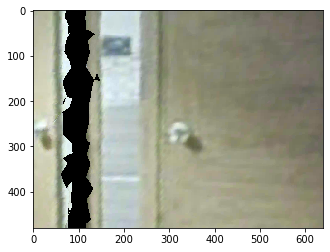

GOAL (DIST, ANG):  [4.19298284 0.07013086]
action_history [1]


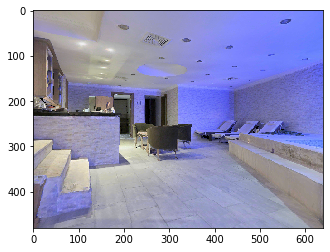

GOAL (DIST, ANG):  [3.94363508 0.07457289]
action_history [1, 1]


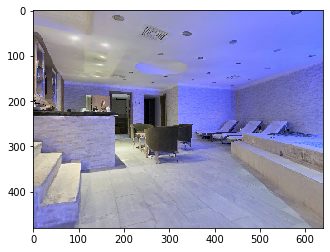

GOAL (DIST, ANG):  [3.69437819 0.07961478]
action_history [1, 1, 1]


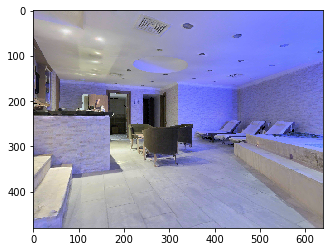

GOAL (DIST, ANG):  [3.44522625 0.0853857 ]
action_history [1, 1, 1, 1]


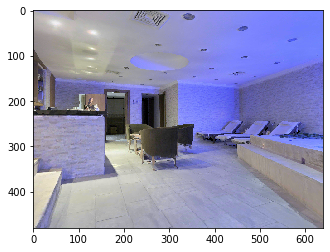

GOAL (DIST, ANG):  [3.19620863 0.09205638]
action_history [1, 1, 1, 1, 1]


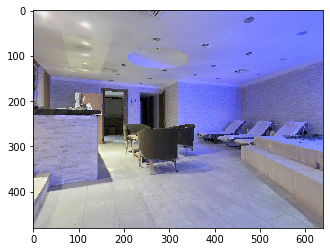

GOAL (DIST, ANG):  [3.19620863 6.20070874]
action_history [1, 1, 1, 1, 1, 2]


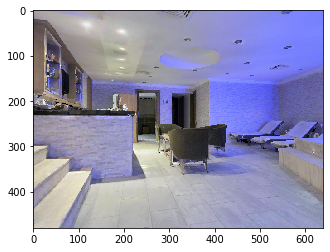

GOAL (DIST, ANG):  [2.94713029 6.19372025]
action_history [1, 1, 1, 1, 1, 2, 1]


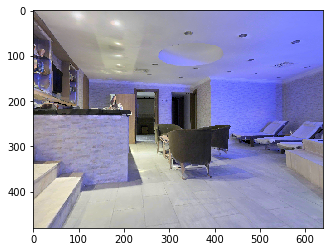

GOAL (DIST, ANG):  [2.94713029 0.08506789]
action_history [1, 1, 1, 1, 1, 2, 1, 3]


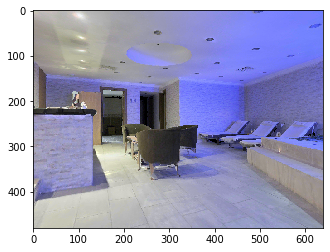

GOAL (DIST, ANG):  [2.69811838 0.09294072]
action_history [1, 1, 1, 1, 1, 2, 1, 3, 1]


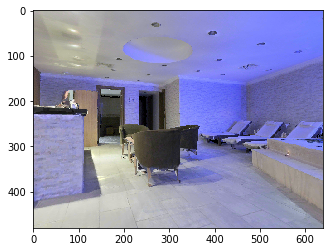

GOAL (DIST, ANG):  [2.69811838 6.20159308]
action_history [1, 1, 1, 1, 1, 2, 1, 3, 1, 2]


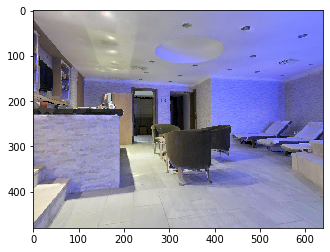

GOAL (DIST, ANG):  [2.44903473 6.19327318]
action_history [1, 1, 1, 1, 1, 2, 1, 3, 1, 2, 1]


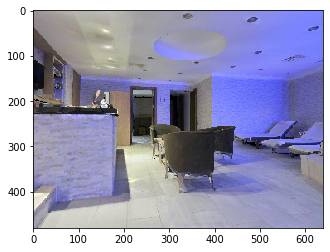

GOAL (DIST, ANG):  [2.44903473 0.08462082]
action_history [1, 1, 1, 1, 1, 2, 1, 3, 1, 2, 1, 3]


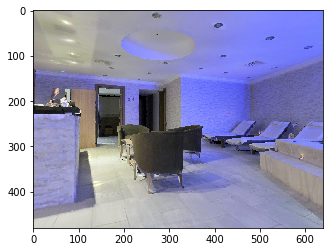

GOAL (DIST, ANG):  [2.20003038 0.09422527]
action_history [1, 1, 1, 1, 1, 2, 1, 3, 1, 2, 1, 3, 1]


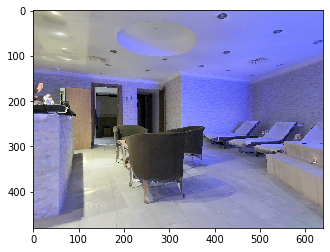

GOAL (DIST, ANG):  [2.20003038 6.20287763]
action_history [1, 1, 1, 1, 1, 2, 1, 3, 1, 2, 1, 3, 1, 2]


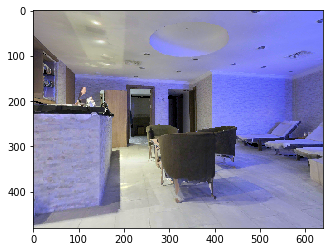

GOAL (DIST, ANG):  [1.95093907 6.19259759]
action_history [1, 1, 1, 1, 1, 2, 1, 3, 1, 2, 1, 3, 1, 2, 1]


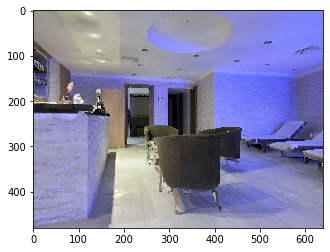

GOAL (DIST, ANG):  [1.95093907 0.08394524]
action_history [1, 1, 1, 1, 1, 2, 1, 3, 1, 2, 1, 3, 1, 2, 1, 3]


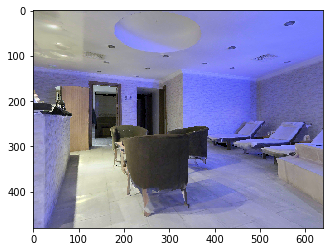

GOAL (DIST, ANG):  [1.70194894 0.09626198]
action_history [1, 1, 1, 1, 1, 2, 1, 3, 1, 2, 1, 3, 1, 2, 1, 3, 1]


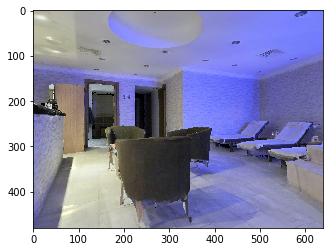

GOAL (DIST, ANG):  [1.70194894 6.20491434]
action_history [1, 1, 1, 1, 1, 2, 1, 3, 1, 2, 1, 3, 1, 2, 1, 3, 1, 2]


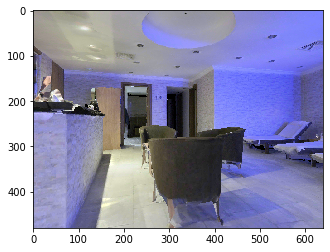

GOAL (DIST, ANG):  [1.45284531 6.19145895]
action_history [1, 1, 1, 1, 1, 2, 1, 3, 1, 2, 1, 3, 1, 2, 1, 3, 1, 2, 1]


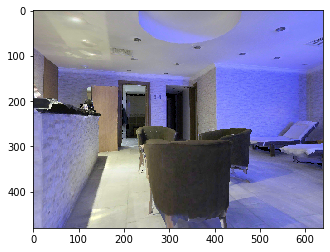

GOAL (DIST, ANG):  [1.45284531 0.08280659]
action_history [1, 1, 1, 1, 1, 2, 1, 3, 1, 2, 1, 3, 1, 2, 1, 3, 1, 2, 1, 3]


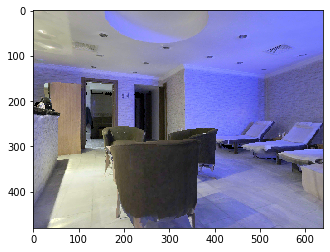

GOAL (DIST, ANG):  [1.20387959 0.09998357]
action_history [1, 1, 1, 1, 1, 2, 1, 3, 1, 2, 1, 3, 1, 2, 1, 3, 1, 2, 1, 3, 1]


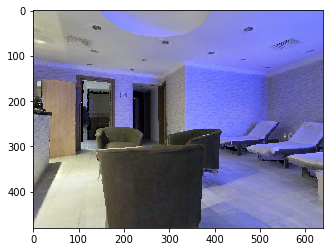

GOAL (DIST, ANG):  [1.20387959 6.20863593]
action_history [1, 1, 1, 1, 1, 2, 1, 3, 1, 2, 1, 3, 1, 2, 1, 3, 1, 2, 1, 3, 1, 2]


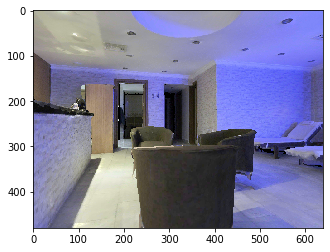

GOAL (DIST, ANG):  [0.95475586 6.1891324 ]
action_history [1, 1, 1, 1, 1, 2, 1, 3, 1, 2, 1, 3, 1, 2, 1, 3, 1, 2, 1, 3, 1, 2, 1]


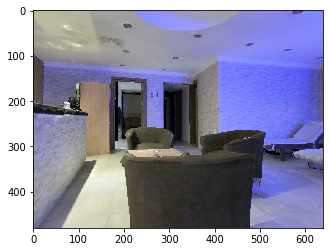

GOAL (DIST, ANG):  [0.95475586 0.08048005]
action_history [1, 1, 1, 1, 1, 2, 1, 3, 1, 2, 1, 3, 1, 2, 1, 3, 1, 2, 1, 3, 1, 2, 1, 3]


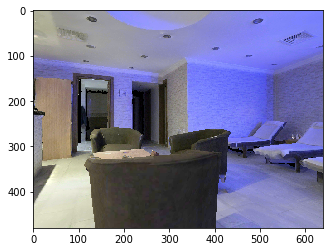

GOAL (DIST, ANG):  [0.70585129 0.1089578 ]
action_history [1, 1, 1, 1, 1, 2, 1, 3, 1, 2, 1, 3, 1, 2, 1, 3, 1, 2, 1, 3, 1, 2, 1, 3, 1]


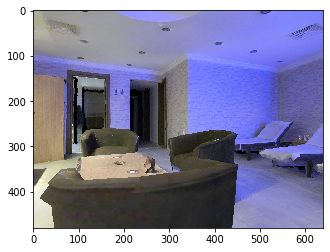

GOAL (DIST, ANG):  [0.70585129 6.21761016]
action_history [1, 1, 1, 1, 1, 2, 1, 3, 1, 2, 1, 3, 1, 2, 1, 3, 1, 2, 1, 3, 1, 2, 1, 3, 1, 2]


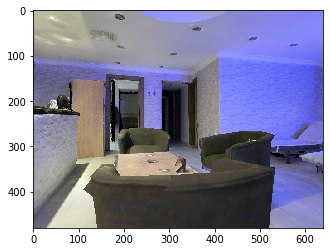

GOAL (DIST, ANG):  [0.45668243 6.18173045]
action_history [1, 1, 1, 1, 1, 2, 1, 3, 1, 2, 1, 3, 1, 2, 1, 3, 1, 2, 1, 3, 1, 2, 1, 3, 1, 2, 1]


GOAL IS BELIEVED TO BE REACHED before planning




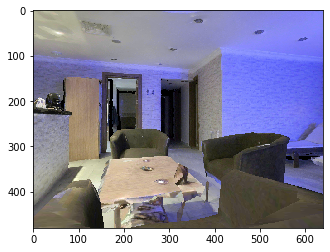

episode over after 28 steps


{'distance_to_goal': 2.8424642086029053,
 'success': 0.0,
 'spl': 0.0,
 'softspl': 0.4389067430490875}

In [8]:
from collections import defaultdict
from typing import Dict, Optional
import quaternion
%matplotlib inline

agg_metrics: Dict = defaultdict(float)

#observations = env.reset()
rtra = [-0.5, 0.04610800743103027, 3.0]
ang = -0.5
rrot = quaternion.from_euler_angles(np.array([0, ang, 0]))
env._sim.get_observations_at(position=rtra, rotation=rrot, keep_agent_at_new_pose=True)

num_episodes = len(env.episodes)
count_episodes = 0
max_steps = 40
while count_episodes < num_episodes:
    agent.reset()
    #observations = env.reset()
    num_steps = 0
    while not env.episode_over and num_steps < max_steps:
        observations['depth'] = observations['depth'] * (dmax - dmin) + dmin
        #print(observations['compass'])
        action = agent.act(observations)
        plt.imshow(observations['rgb'])
        plt.show()
        observations = env.step(action)
        num_steps += 1
    print("episode over after {} steps".format(num_steps))

    metrics = env.get_metrics()
    for m, v in metrics.items():
        agg_metrics[m] += v
    count_episodes += 1

avg_metrics = {k: v / count_episodes for k, v in agg_metrics.items()}
avg_metrics

In [9]:
%%capture cap_out
print(agent.action_history)

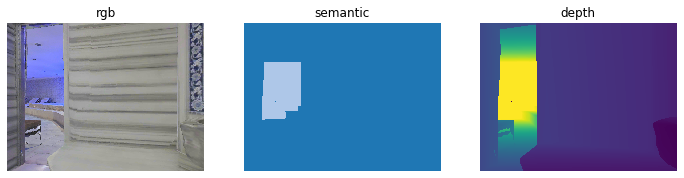

turn left
rgb mean: 141.35864583333333


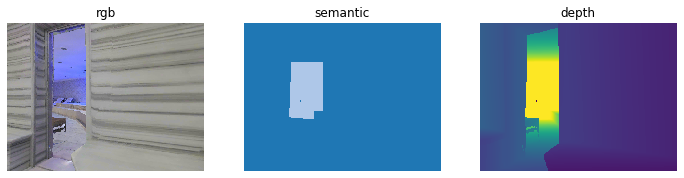

turn left
rgb mean: 141.28759331597223


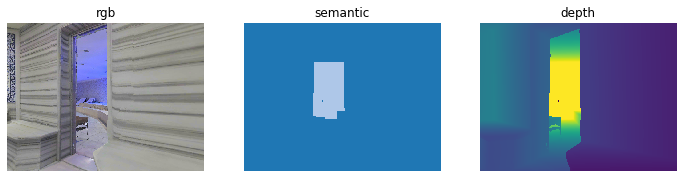

move_forward
rgb mean: 141.81425347222222


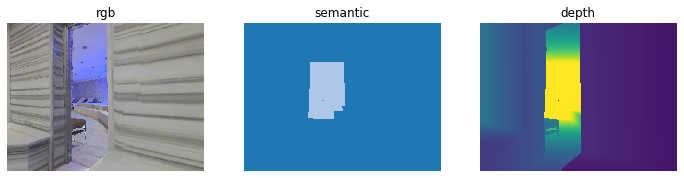

move_forward
rgb mean: 142.07326497395835


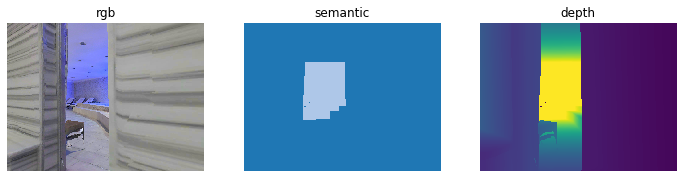

move_forward
rgb mean: 142.3459060329861


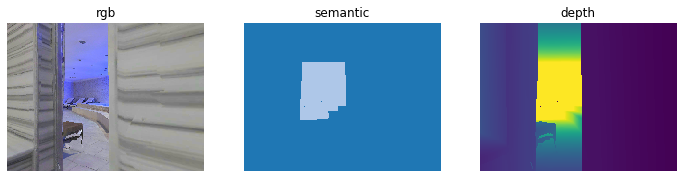

move_forward
rgb mean: 142.3459060329861


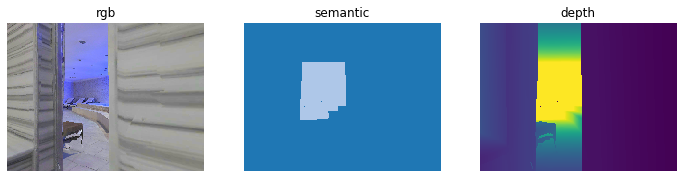

move_forward
rgb mean: 142.3459060329861


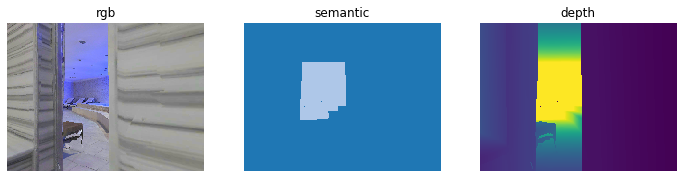

turn left
rgb mean: 141.4463943142361


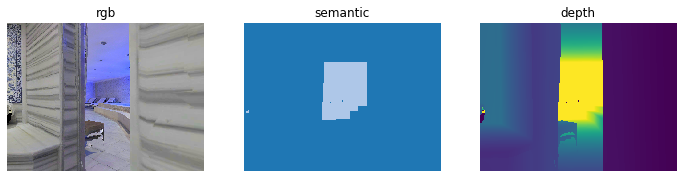

turn left
rgb mean: 139.6048806423611


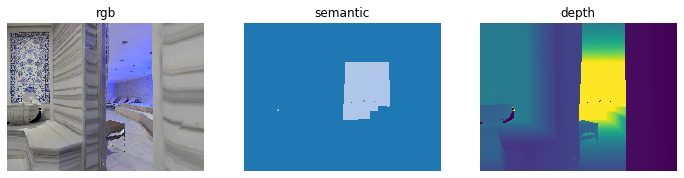

turn left
rgb mean: 137.50604817708333


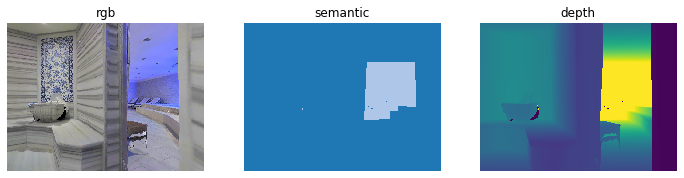

In [10]:
max_steps = 10

action_mapping = {
    #0: 'stop',
    1: 'move_forward',
    2: 'turn left',
    #3: 'turn right'
}

for i in range(len(env.episodes)):
    observations = env.reset()
    display_sample(observations['rgb'], observations.get('depth'), np.squeeze(observations['depth']))
    
    count_steps = 0
    while count_steps < max_steps:
        action = random.choice(list(action_mapping.keys()))
        print(action_mapping[action])
        observations = env.step(action)
        print('rgb mean:', observations['rgb'].mean())
        display_sample(observations['rgb'], observations.get('depth'), np.squeeze(observations['depth']))

        count_steps += 1
        if env.episode_over:
            break

In [11]:
env.close()

In [12]:
# benchmark = habitat.Benchmark(args.task_config)
# metrics = benchmark.evaluate(agent)
# for k, v in metrics.items():
#     habitat.logger.info("{}: {:.3f}".format(k, v))
#     print(k, v)